In [1]:
import pandas as pd
import numpy as np
import scipy.sparse


import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

train = pd.read_json('input/train.json', orient='columns')
train.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10.0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000.0,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue


- start with bath, beds, manager id, build id, price
- transform manager id and building id into average interest level
- standardize inputs
- split into train/validation stratfied
- take sample from both train and validation
- train lr

## Helper Functions

In [3]:
def createSamples(X_train, y_train, X_test, y_test, num_train= 1000, num_test=400):
    
    nums = np.arange(X_train.shape[0])
    np.random.shuffle(nums)
    X_train_samp = X_train.iloc[nums[:num_train]]
    y_train_samp = y_train.iloc[nums[:num_train]]


    test_nums = np.arange(X_test.shape[0])
    np.random.shuffle(test_nums)

    X_test_samp = X_test.iloc[test_nums[:num_test]]
    y_test_samp = y_test.iloc[test_nums[:num_test]]
    return X_train_samp, y_train_samp, X_test_samp, y_test_samp

def get_accuracy(preds, y_test_samp):
    return (preds == y_test_samp).sum() / preds.shape[0] 

In [4]:
def subAndSample(subset, num_train=20000, num_test=2000, comp=False):
    X = subset.drop('enc_interest', axis=1)
    y = subset.enc_interest
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    if comp:
        return X_train, y_train, X_test, y_test 
    else:
        return createSamples(X_train, y_train, X_test, y_test, num_train=num_train, num_test=num_test)

In [5]:
def standardize(X_train, X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test

In [6]:
train['enc_interest'] = train.interest_level.map({'low': 0, 'medium': 1, 'high':2})

## only baths, beds, price

In [19]:
subset = train[['bathrooms', 'bedrooms', 'price', 'enc_interest']]

In [26]:
for i in range(3):
    val_losses = np.array([])
    train_losses = np.array([])
    X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)

    X_train, X_test = standardize(X_train, X_test)

    dtrain = xgb.DMatrix(X_train, label= y_train)
    dval = xgb.DMatrix(X_test, label=y_test)

    # specify parameters via map
    watchlist = [(dtrain,'train'), (dval,'val')]
    param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
    num_round = 20
    bst = xgb.train(param, dtrain, num_round, watchlist)
    preds = bst.predict(dval)
    val_loss = log_loss(y_test, preds)
    print('val loss ',val_loss)
    train_loss = log_loss(y_train, bst.predict(dtrain))
    train_losses = np.append(train_losses, train_loss)
    val_losses = np.append(val_losses, val_loss)
print('avg val loss', np.mean(val_losses))
print('avg train loss', np.mean(train_losses))
    

[0]	train-merror:0.299891	val-merror:0.300375
[1]	train-merror:0.29903	val-merror:0.299767
[2]	train-merror:0.298574	val-merror:0.298855
[3]	train-merror:0.298574	val-merror:0.298855
[4]	train-merror:0.298321	val-merror:0.298754
[5]	train-merror:0.298169	val-merror:0.298754
[6]	train-merror:0.298067	val-merror:0.298754
[7]	train-merror:0.297915	val-merror:0.298247
[8]	train-merror:0.297865	val-merror:0.298349
[9]	train-merror:0.297688	val-merror:0.298146
[10]	train-merror:0.297839	val-merror:0.298349
[11]	train-merror:0.297839	val-merror:0.298349
[12]	train-merror:0.297839	val-merror:0.298551
[13]	train-merror:0.297814	val-merror:0.298349
[14]	train-merror:0.297839	val-merror:0.298551
[15]	train-merror:0.297789	val-merror:0.298653
[16]	train-merror:0.297789	val-merror:0.298551
[17]	train-merror:0.297789	val-merror:0.298551
[18]	train-merror:0.297561	val-merror:0.298653
[19]	train-merror:0.297561	val-merror:0.298653
val loss  0.698312317973
[0]	train-merror:0.299258	val-merror:0.300983


## Lat Long

In [9]:
subset= train[['bathrooms', 'bedrooms', 'price','enc_interest', 'latitude', 'longitude']]

In [10]:
for i in range(3):
    val_losses = np.array([])
    train_losses = np.array([])
    X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)

    X_train, X_test = standardize(X_train, X_test)

    dtrain = xgb.DMatrix(X_train, label= y_train)
    dval = xgb.DMatrix(X_test, label=y_test)

    # specify parameters via map
    watchlist = [(dtrain,'train'), (dval,'val')]
    param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
    num_round = 20
    bst = xgb.train(param, dtrain, num_round, watchlist)
    preds = bst.predict(dval)
    val_loss = log_loss(y_test, preds)
    print('val loss ',val_loss)
    train_loss = log_loss(y_train, bst.predict(dtrain))
    train_losses = np.append(train_losses, train_loss)
    val_losses = np.append(val_losses, val_loss)
print('avg val loss', np.mean(val_losses))
print('avg train loss', np.mean(train_losses))

[0]	train-merror:0.29984	val-merror:0.300476
[1]	train-merror:0.298295	val-merror:0.300881
[2]	train-merror:0.29746	val-merror:0.301185
[3]	train-merror:0.293787	val-merror:0.299159
[4]	train-merror:0.292672	val-merror:0.29764
[5]	train-merror:0.292571	val-merror:0.296728
[6]	train-merror:0.29095	val-merror:0.298045
[7]	train-merror:0.290266	val-merror:0.295512
[8]	train-merror:0.288949	val-merror:0.296019
[9]	train-merror:0.287151	val-merror:0.295917
[10]	train-merror:0.285707	val-merror:0.295715
[11]	train-merror:0.285175	val-merror:0.296728
[12]	train-merror:0.284795	val-merror:0.296424
[13]	train-merror:0.283934	val-merror:0.2946
[14]	train-merror:0.283655	val-merror:0.294195
[15]	train-merror:0.283554	val-merror:0.2946
[16]	train-merror:0.28325	val-merror:0.294296
[17]	train-merror:0.283048	val-merror:0.294398
[18]	train-merror:0.282186	val-merror:0.294094
[19]	train-merror:0.281882	val-merror:0.293891
val loss  0.674933778821
[0]	train-merror:0.299916	val-merror:0.300375
[1]	trai

## building_id

In [33]:
subset= train[['bathrooms', 'bedrooms', 'price','enc_interest', 'building_id']]


X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)
h = FeatureHasher(input_type='string')

hashed = h.fit_transform(X_train.building_id)


test_hashed = h.transform(X_test.building_id)

X_train = X_train.drop('building_id', axis=1)
X_test = X_test.drop('building_id', axis=1)

X_train[['bathrooms', 'bedrooms', 'price']], X_test[['bathrooms', 'bedrooms', 'price']] =\
standardize(X_train[['bathrooms', 'bedrooms', 'price']],\
            X_test[['bathrooms', 'bedrooms', 'price']])

X_train_concat = scipy.sparse.hstack((X_train,hashed))

X_test_concat = scipy.sparse.hstack((X_test, test_hashed))

dtrain = xgb.DMatrix(X_train_concat, label= y_train)
dval = xgb.DMatrix(X_test_concat, label=y_test)

# specify parameters via map
watchlist = [(dtrain,'train'), (dval,'val')]
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 20
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.296294	val-merror:0.297741
[1]	train-merror:0.29323	val-merror:0.297538
[2]	train-merror:0.292115	val-merror:0.296626
[3]	train-merror:0.289886	val-merror:0.295512
[4]	train-merror:0.292191	val-merror:0.29764
[5]	train-merror:0.291659	val-merror:0.296221
[6]	train-merror:0.289633	val-merror:0.294702
[7]	train-merror:0.289253	val-merror:0.2946
[8]	train-merror:0.288443	val-merror:0.293283
[9]	train-merror:0.288113	val-merror:0.293385
[10]	train-merror:0.287505	val-merror:0.29612
[11]	train-merror:0.286771	val-merror:0.295512
[12]	train-merror:0.285555	val-merror:0.296019
[13]	train-merror:0.285023	val-merror:0.295309
[14]	train-merror:0.284061	val-merror:0.294499
[15]	train-merror:0.284441	val-merror:0.293689
[16]	train-merror:0.283807	val-merror:0.29379
[17]	train-merror:0.283225	val-merror:0.294398
[18]	train-merror:0.282516	val-merror:0.294296
[19]	train-merror:0.28282	val-merror:0.293992


In [32]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.657810807608


0.64327181387724686

Another run to check if improvement holds

In [34]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.655097364907


0.64457443448196794

## Manager Id

In [37]:
subset= train[['bathrooms', 'bedrooms', 'price','enc_interest', 'manager_id']]


X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)
h = FeatureHasher(input_type='string')

hashed = h.fit_transform(X_train.manager_id)


test_hashed = h.transform(X_test.manager_id)

X_train = X_train.drop('manager_id', axis=1)
X_test = X_test.drop('manager_id', axis=1)

X_train[['bathrooms', 'bedrooms', 'price']], X_test[['bathrooms', 'bedrooms', 'price']] =\
standardize(X_train[['bathrooms', 'bedrooms', 'price']],\
            X_test[['bathrooms', 'bedrooms', 'price']])

X_train_concat = scipy.sparse.hstack((X_train,hashed))

X_test_concat = scipy.sparse.hstack((X_test, test_hashed))

dtrain = xgb.DMatrix(X_train_concat, label= y_train)
dval = xgb.DMatrix(X_test_concat, label=y_test)

# specify parameters via map
watchlist = [(dtrain,'train'), (dval,'val')]
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 20
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.299385	val-merror:0.300476
[1]	train-merror:0.299005	val-merror:0.299362
[2]	train-merror:0.298802	val-merror:0.300172
[3]	train-merror:0.29594	val-merror:0.29764
[4]	train-merror:0.296066	val-merror:0.300983
[5]	train-merror:0.295104	val-merror:0.300577
[6]	train-merror:0.294673	val-merror:0.298754
[7]	train-merror:0.293762	val-merror:0.298247
[8]	train-merror:0.29247	val-merror:0.298653
[9]	train-merror:0.291558	val-merror:0.29693
[10]	train-merror:0.291001	val-merror:0.29764
[11]	train-merror:0.291102	val-merror:0.297336
[12]	train-merror:0.289861	val-merror:0.297842
[13]	train-merror:0.288974	val-merror:0.29764
[14]	train-merror:0.288291	val-merror:0.296221
[15]	train-merror:0.287835	val-merror:0.295208
[16]	train-merror:0.287227	val-merror:0.292878
[17]	train-merror:0.28596	val-merror:0.294904
[18]	train-merror:0.285707	val-merror:0.294398
[19]	train-merror:0.285049	val-merror:0.292473


In [36]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.668980750305


0.6517843306251726

Second run

In [38]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.676009044779


0.65369270005257252

## Date

In [39]:
train['created'] = pd.to_datetime(train.created)

In [40]:
train['year'] = train.created.dt.year

In [43]:
train['month'] = train.created.dt.month

In [50]:
train['hour'] = train.created.dt.hour

In [44]:
train.month.unique()

array([6, 4, 5])

In [49]:
train.groupby('month').enc_interest.mean()

month
4    0.385412
5    0.386656
6    0.377625
Name: enc_interest, dtype: float64

In [51]:
train.groupby('hour').enc_interest.mean()

hour
0     0.727273
1     0.109062
2     0.339656
3     0.328925
4     0.350129
5     0.492960
6     0.508097
7     0.412607
8     0.440476
9     0.651852
10    0.595070
11    0.515766
12    0.575758
13    0.551948
14    0.517903
15    0.577689
16    0.613514
17    0.641084
18    0.531111
19    0.590226
20    0.654450
21    0.691011
22    0.733813
23    0.755814
Name: enc_interest, dtype: float64

In [54]:
train.groupby('hour').size()

hour
0        55
1      5749
2     10596
3      8318
4      5021
5      7954
6      4446
7      1047
8       336
9       135
10      284
11      444
12      693
13      616
14      782
15      753
16      370
17      443
18      450
19      266
20      191
21      178
22      139
23       86
dtype: int64

In [55]:
subset = train[['bathrooms', 'hour', 'bedrooms', 'price', 'enc_interest']]

In [57]:
for i in range(3):
    val_losses = np.array([])
    train_losses = np.array([])
    X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)

    X_train[['bathrooms', 'hour', 'bedrooms', 'price']], X_test[['bathrooms', 'hour', 'bedrooms', 'price']] =\
    standardize(X_train[['bathrooms', 'hour', 'bedrooms', 'price']], 
                X_test[['bathrooms', 'hour', 'bedrooms', 'price']])

    dtrain = xgb.DMatrix(X_train, label= y_train)
    dval = xgb.DMatrix(X_test, label=y_test)

    # specify parameters via map
    watchlist = [(dtrain,'train'), (dval,'val')]
    param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
    num_round = 20
    bst = xgb.train(param, dtrain, num_round, watchlist)
    preds = bst.predict(dval)
    val_loss = log_loss(y_test, preds)
    print('val loss ',val_loss)
    train_loss = log_loss(y_train, bst.predict(dtrain))
    train_losses = np.append(train_losses, train_loss)
    val_losses = np.append(val_losses, val_loss)
print('avg val loss', np.mean(val_losses))
print('avg train loss', np.mean(train_losses))
    

[0]	train-merror:0.299435	val-merror:0.299666
[1]	train-merror:0.296978	val-merror:0.297943
[2]	train-merror:0.296725	val-merror:0.297437
[3]	train-merror:0.297915	val-merror:0.298146
[4]	train-merror:0.29599	val-merror:0.297032
[5]	train-merror:0.295383	val-merror:0.296323
[6]	train-merror:0.2948	val-merror:0.29612
[7]	train-merror:0.294547	val-merror:0.295411
[8]	train-merror:0.293584	val-merror:0.295512
[9]	train-merror:0.293483	val-merror:0.295613
[10]	train-merror:0.292596	val-merror:0.295411
[11]	train-merror:0.29209	val-merror:0.295512
[12]	train-merror:0.291786	val-merror:0.295208
[13]	train-merror:0.290722	val-merror:0.293486
[14]	train-merror:0.29057	val-merror:0.293587
[15]	train-merror:0.290342	val-merror:0.292169
[16]	train-merror:0.290469	val-merror:0.292676
[17]	train-merror:0.290089	val-merror:0.292169
[18]	train-merror:0.289785	val-merror:0.292574
[19]	train-merror:0.289734	val-merror:0.293081
val loss  0.668875213023
[0]	train-merror:0.298473	val-merror:0.298247
[1]	t

## Photos

In [11]:
train['num_photos'] = train.photos.apply(lambda x: len(x))

In [12]:
train.groupby('enc_interest').num_photos.mean()

enc_interest
0    5.524647
1    5.813251
2    5.738474
Name: num_photos, dtype: float64

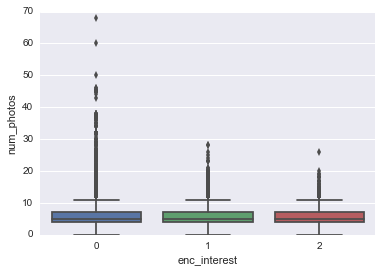

In [62]:
sns.boxplot(data=train, x='enc_interest', y='num_photos')

In [18]:
train['no_photos'] = train.num_photos == 0

In [20]:
train['no_photos'] = train.no_photos.astype(int)

In [17]:
train[train.num_photos == 0].enc_interest.mean()

0.061687413554633475

In [22]:
subset = train[['bathrooms', 'bedrooms', 'price', 'num_photos', 'no_photos', 'enc_interest']]

In [25]:
for i in range(3):
    val_losses = np.array([])
    train_losses = np.array([])
    X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)
    X_train, X_test = standardize(X_train, X_test)
    dtrain = xgb.DMatrix(X_train, label= y_train)
    dval = xgb.DMatrix(X_test, label=y_test)

    # specify parameters via map
    watchlist = [(dtrain,'train'), (dval,'val')]
    param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
    num_round = 20
    bst = xgb.train(param, dtrain, num_round, watchlist)
    preds = bst.predict(dval)
    val_loss = log_loss(y_test, preds)
    print('val loss ',val_loss)
    train_loss = log_loss(y_train, bst.predict(dtrain))
    train_losses = np.append(train_losses, train_loss)
    val_losses = np.append(val_losses, val_loss)
print('avg val loss', np.mean(val_losses))
print('avg train loss', np.mean(train_losses))
    

[0]	train-merror:0.299562	val-merror:0.30078
[1]	train-merror:0.29746	val-merror:0.300476
[2]	train-merror:0.297232	val-merror:0.300881
[3]	train-merror:0.29708	val-merror:0.300375
[4]	train-merror:0.29713	val-merror:0.300476
[5]	train-merror:0.296244	val-merror:0.299767
[6]	train-merror:0.295864	val-merror:0.299767
[7]	train-merror:0.296117	val-merror:0.300274
[8]	train-merror:0.296244	val-merror:0.298653
[9]	train-merror:0.295915	val-merror:0.298653
[10]	train-merror:0.29556	val-merror:0.298146
[11]	train-merror:0.295585	val-merror:0.298146
[12]	train-merror:0.295636	val-merror:0.298045
[13]	train-merror:0.295585	val-merror:0.298653
[14]	train-merror:0.29518	val-merror:0.298754
[15]	train-merror:0.295585	val-merror:0.298653
[16]	train-merror:0.295509	val-merror:0.298551
[17]	train-merror:0.295231	val-merror:0.299058
[18]	train-merror:0.295003	val-merror:0.299362
[19]	train-merror:0.294851	val-merror:0.299666
val loss  0.6805181023
[0]	train-merror:0.299435	val-merror:0.301287
[1]	tra

# Features nlp

In [9]:
train['feat_str'] = train.features.apply(lambda x: " ".join(x))

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train.feat_str)

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(train_counts)
train_tf = tf_transformer.transform(train_counts)


In [15]:
TfidfTransformer?

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
clf = MultinomialNB()

In [25]:
clf.fit(train_tf, train.enc_interest)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
preds.sum()

1070

In [30]:
preds = clf.predict_proba(train_tf)

In [31]:
log_loss(train.enc_interest, preds)

0.7584492522367966

In [28]:
get_accuracy(train.enc_interest, preds)

0.6948046685038094

In [77]:
subset = train[['feat_str', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])

X_train_concat = np.array(np.concatenate([a for a in X_train.values]))
X_test_concat = np.array(np.concatenate([a for a in X_test.values]))

text_clf.fit(X_train_concat, y_train.values)
preds = text_clf.predict(X_test_concat)
probs = text_clf.predict_proba(X_test_concat)
print(get_accuracy(y_test, preds))
log_loss(y_test,probs)

0.691723229663


0.76581763436551764

In [81]:
subset = train[['feat_str', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB())])

X_train_concat = np.array(np.concatenate([a for a in X_train.values]))
X_test_concat = np.array(np.concatenate([a for a in X_test.values]))

text_clf.fit(X_train_concat, y_train.values)
preds = text_clf.predict(X_test_concat)
probs = text_clf.predict_proba(X_test_concat)
print(get_accuracy(y_test, preds))
log_loss(y_test,probs)

0.693344139398


0.76033893198013003

In [85]:
subset = train[['feat_str', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB())])

X_train_concat = np.array(np.concatenate([a for a in X_train.values]))
X_test_concat = np.array(np.concatenate([a for a in X_test.values]))

text_clf.fit(X_train_concat, y_train.values)
preds = text_clf.predict(X_test_concat)
probs = text_clf.predict_proba(X_test_concat)
print(get_accuracy(y_test, preds))
log_loss(y_test,probs)

0.694154594266


0.76523884493207528

In [172]:
subset = train[['feat_str', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB())])

X_train_concat = np.array(np.concatenate([a for a in X_train.values]))
X_test_concat = np.array(np.concatenate([a for a in X_test.values]))

text_clf.fit(X_train_concat, y_train.values)
preds = text_clf.predict(X_test_concat)
probs = text_clf.predict_proba(X_test_concat)
print(get_accuracy(y_test, preds))
log_loss(y_test,probs)

0.692128457097


0.79231916508995459

In [90]:
from sklearn.linear_model import SGDClassifier

In [171]:
subset = train[['feat_str', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-4, n_iter=10)) ])

X_train_concat = np.array(np.concatenate([a for a in X_train.values]))
X_test_concat = np.array(np.concatenate([a for a in X_test.values]))

text_clf.fit(X_train_concat, y_train.values)
preds = text_clf.predict(X_test_concat)
train_preds = text_clf.predict(X_train_concat)

print(get_accuracy(y_test, preds))
print(get_accuracy(y_train, train_preds))



0.695674197143
0.696486917758


- split to train and test
- fit svm on train
- predict svm on test
- add predictions as feature to classifier
- get accuracy

In [227]:
subset = train[['feat_str','bathrooms', 'bedrooms', 'price', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)


from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-5, n_iter=5)) ])


text_clf.fit(X_train.feat_str.values, y_train.values)

preds = text_clf.predict(X_test.feat_str.values)

train_preds = text_clf.predict(X_train.feat_str.values)

X_test['svm_preds'] = preds
X_train['svm_preds'] = train_preds

X_train = X_train.drop('feat_str', axis=1)
X_test= X_test.drop('feat_str', axis=1)

X_train, X_test = standardize(X_train, X_test)

In [228]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [229]:
preds = lr.predict(X_test)
probs = lr.predict_proba(X_test)
print(get_accuracy(preds, y_test))


print(log_loss(y_test, probs))

0.69851078918
0.722678949691


In [205]:
subset = train[['feat_str','bathrooms', 'bedrooms', 'price', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)


from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB())])


text_clf.fit(X_train.feat_str.values, y_train.values)

preds = text_clf.predict(X_test.feat_str.values)

train_preds = text_clf.predict(X_train.feat_str.values)

X_test['svm_preds'] = preds
X_train['svm_preds'] = train_preds

X_train = X_train.drop('feat_str', axis=1)
X_test= X_test.drop('feat_str', axis=1)

X_train, X_test = standardize(X_train, X_test)

In [206]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)


preds = lr.predict(X_test)

print(get_accuracy(preds, y_test))

get_accuracy(lr.predict(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [183]:
lr.coef_

array([[ -1.39618363e-01,  -4.36800222e-01,   5.95738072e-04,
         -4.06530331e-01],
       [  3.69696279e-02,   2.33803701e-03,   3.88956992e-05,
          1.70429378e-01],
       [  1.02648735e-01,   4.34462185e-01,  -6.34633771e-04,
          2.36100953e-01]])

In [ ]:
clf', SGDClassifier(loss='hinge', penalty='l2',
...                                            alpha=1e-3, n_iter=5, random_state=42))

### Concatenate text and regular matrices

In [277]:
import scipy.sparse

from sklearn.pipeline import Pipeline
text_proc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])


subset = train[['feat_str','bathrooms', 'bedrooms', 'price', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

text_proc.fit(X_train.feat_str.values)

tr_text_mat = text_proc.transform(X_train.feat_str.values)

test_text_mat = text_proc.transform(X_test.feat_str.values)

X_train =X_train.drop('feat_str', axis=1)
X_test =X_test.drop('feat_str', axis=1)
X_train, X_test = standardize(X_train, X_test)

X_train_concat = scipy.sparse.hstack((X_train,tr_text_mat))

X_test_concat = scipy.sparse.hstack((X_test, test_text_mat))

In [278]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train_concat, y_train)

preds = lr.predict(X_test_concat)

print(get_accuracy(preds, y_test))

get_accuracy(lr.predict(X_train_concat), y_train)

0.706716644717


0.71573668346799724

###  Xgboost with concatenated features

In [297]:
import scipy.sparse

from sklearn.pipeline import Pipeline
text_proc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])


subset = train[['feat_str','bathrooms', 'bedrooms', 'price', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

text_proc.fit(X_train.feat_str.values)

tr_text_mat = text_proc.transform(X_train.feat_str.values)

test_text_mat = text_proc.transform(X_test.feat_str.values)

X_train =X_train.drop('feat_str', axis=1)
X_test =X_test.drop('feat_str', axis=1)
X_train, X_test = standardize(X_train, X_test)

X_train_concat = scipy.sparse.hstack((X_train,tr_text_mat))

X_test_concat = scipy.sparse.hstack((X_test, test_text_mat))

In [298]:
dtrain = xgb.DMatrix(X_train_concat, label= y_train)
dval = xgb.DMatrix(X_test_concat, label=y_test)

# specify parameters via map
watchlist = [(dtrain,'train'), (dval,'val')]
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 15
bst = xgb.train(param, dtrain, num_round, watchlist)

preds = bst.predict(dval)

print(log_loss(y_test, preds))

log_loss(y_train, bst.predict(dtrain))

[0]	train-merror:0.294344	val-merror:0.293385
[1]	train-merror:0.292622	val-merror:0.292574
[2]	train-merror:0.289405	val-merror:0.291764
[3]	train-merror:0.288189	val-merror:0.291257
[4]	train-merror:0.285606	val-merror:0.291662
[5]	train-merror:0.282237	val-merror:0.289535
[6]	train-merror:0.281224	val-merror:0.288927
[7]	train-merror:0.279856	val-merror:0.288623
[8]	train-merror:0.279046	val-merror:0.288623
[9]	train-merror:0.278286	val-merror:0.288319
[10]	train-merror:0.277222	val-merror:0.286901
[11]	train-merror:0.275044	val-merror:0.286496
[12]	train-merror:0.274107	val-merror:0.2868
[13]	train-merror:0.273524	val-merror:0.286394
[14]	train-merror:0.272967	val-merror:0.285989


Settings that seem best so far:
- use_idf =True
- no stopwords
- ngram range 2 or 3

Xgboost on text features concatenated with regular features seems like the way to go

### Description

In [307]:
from sklearn.pipeline import Pipeline
text_proc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])



In [308]:
subset = train[['description','bathrooms', 'bedrooms', 'price', 'enc_interest']]

In [309]:
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)

text_proc.fit(X_train.description.values)

tr_text_mat = text_proc.transform(X_train.description.values)

test_text_mat = text_proc.transform(X_test.description.values)

X_train =X_train.drop('description', axis=1)
X_test =X_test.drop('description', axis=1)
X_train, X_test = standardize(X_train, X_test)

X_train_concat = scipy.sparse.hstack((X_train,tr_text_mat))

X_test_concat = scipy.sparse.hstack((X_test, test_text_mat))

In [314]:
dtrain = xgb.DMatrix(X_train_concat, label= y_train)
dval = xgb.DMatrix(X_test_concat, label=y_test)

# specify parameters via map
watchlist = [(dtrain,'train'), (dval,'val')]
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 15
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.297688	val-merror:0.294803
[1]	train-merror:0.295307	val-merror:0.295715
[2]	train-merror:0.293584	val-merror:0.29612
[3]	train-merror:0.28943	val-merror:0.294803
[4]	train-merror:0.285758	val-merror:0.293283
[5]	train-merror:0.284162	val-merror:0.293081
[6]	train-merror:0.283174	val-merror:0.29146
[7]	train-merror:0.279628	val-merror:0.292676
[8]	train-merror:0.277551	val-merror:0.290852
[9]	train-merror:0.275474	val-merror:0.289535
[10]	train-merror:0.272764	val-merror:0.288623
[11]	train-merror:0.2717	val-merror:0.287813
[12]	train-merror:0.269978	val-merror:0.28913
[13]	train-merror:0.268154	val-merror:0.288826
[14]	train-merror:0.264887	val-merror:0.287711


In [315]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.664866422157


0.6263888617674026

### Features and Description

In [316]:
import scipy.sparse

from sklearn.pipeline import Pipeline
text_proc_feat = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])
text_proc_desc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])


subset = train[['feat_str', 'description', 'bathrooms', 'bedrooms', 'price', 'enc_interest']]
X_train, X_test, y_train, y_test = subAndSample(subset, comp=True)



text_proc_feat.fit(X_train.feat_str.values)
tr_feat_text = text_proc.transform(X_train.feat_str.values)
test_feat_text = text_proc.transform(X_test.feat_str.values)


text_proc_desc.fit(X_train.description.values)
tr_desc_mat = text_proc_desc.transform(X_train.description.values)
test_desc_mat = text_proc_desc.transform(X_test.description.values)


X_train = X_train.drop(['feat_str', 'description'], axis=1)
X_test = X_test.drop(['feat_str', 'description'], axis=1)
X_train, X_test = standardize(X_train, X_test)


X_train_concat = scipy.sparse.hstack((X_train,tr_feat_text, tr_desc_mat))
X_test_concat = scipy.sparse.hstack((X_test, test_feat_text, test_desc_mat))

In [321]:
dtrain = xgb.DMatrix(X_train_concat, label= y_train)
dval = xgb.DMatrix(X_test_concat, label=y_test)

# specify parameters via map
watchlist = [(dtrain,'train'), (dval,'val')]
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 10
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.294952	val-merror:0.294296
[1]	train-merror:0.293534	val-merror:0.293283
[2]	train-merror:0.291431	val-merror:0.291865
[3]	train-merror:0.286416	val-merror:0.289738
[4]	train-merror:0.283655	val-merror:0.287813
[5]	train-merror:0.276817	val-merror:0.285179
[6]	train-merror:0.274157	val-merror:0.28295
[7]	train-merror:0.27127	val-merror:0.282646
[8]	train-merror:0.268965	val-merror:0.282747
[9]	train-merror:0.26742	val-merror:0.280215


In [322]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.644885487823


0.6205642350065651

In [323]:
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 15
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.294952	val-merror:0.294296
[1]	train-merror:0.293534	val-merror:0.293283
[2]	train-merror:0.291431	val-merror:0.291865
[3]	train-merror:0.286416	val-merror:0.289738
[4]	train-merror:0.283655	val-merror:0.287813
[5]	train-merror:0.276817	val-merror:0.285179
[6]	train-merror:0.274157	val-merror:0.28295
[7]	train-merror:0.27127	val-merror:0.282646
[8]	train-merror:0.268965	val-merror:0.282747
[9]	train-merror:0.26742	val-merror:0.280215
[10]	train-merror:0.26514	val-merror:0.280924
[11]	train-merror:0.263646	val-merror:0.280417
[12]	train-merror:0.261645	val-merror:0.280113
[13]	train-merror:0.259365	val-merror:0.277378
[14]	train-merror:0.25744	val-merror:0.276872


In [324]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.63915561909


0.6025585486170203

In [326]:
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 25
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.294952	val-merror:0.294296
[1]	train-merror:0.293534	val-merror:0.293283
[2]	train-merror:0.291431	val-merror:0.291865
[3]	train-merror:0.286416	val-merror:0.289738
[4]	train-merror:0.283655	val-merror:0.287813
[5]	train-merror:0.276817	val-merror:0.285179
[6]	train-merror:0.274157	val-merror:0.28295
[7]	train-merror:0.27127	val-merror:0.282646
[8]	train-merror:0.268965	val-merror:0.282747
[9]	train-merror:0.26742	val-merror:0.280215
[10]	train-merror:0.26514	val-merror:0.280924
[11]	train-merror:0.263646	val-merror:0.280417
[12]	train-merror:0.261645	val-merror:0.280113
[13]	train-merror:0.259365	val-merror:0.277378
[14]	train-merror:0.25744	val-merror:0.276872
[15]	train-merror:0.256123	val-merror:0.276264
[16]	train-merror:0.254831	val-merror:0.274643
[17]	train-merror:0.252982	val-merror:0.274339
[18]	train-merror:0.251159	val-merror:0.274643
[19]	train-merror:0.249842	val-merror:0.274643
[20]	train-merror:0.24893	val-merror:0.274238
[21]	train-merror:0.246473	va

In [327]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.634272339866


0.5737917812620611

In [333]:
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 55
bst = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.294952	val-merror:0.294296
[1]	train-merror:0.293534	val-merror:0.293283
[2]	train-merror:0.291431	val-merror:0.291865
[3]	train-merror:0.286416	val-merror:0.289738
[4]	train-merror:0.283655	val-merror:0.287813
[5]	train-merror:0.276817	val-merror:0.285179
[6]	train-merror:0.274157	val-merror:0.28295
[7]	train-merror:0.27127	val-merror:0.282646
[8]	train-merror:0.268965	val-merror:0.282747
[9]	train-merror:0.26742	val-merror:0.280215
[10]	train-merror:0.26514	val-merror:0.280924
[11]	train-merror:0.263646	val-merror:0.280417
[12]	train-merror:0.261645	val-merror:0.280113
[13]	train-merror:0.259365	val-merror:0.277378
[14]	train-merror:0.25744	val-merror:0.276872
[15]	train-merror:0.256123	val-merror:0.276264
[16]	train-merror:0.254831	val-merror:0.274643
[17]	train-merror:0.252982	val-merror:0.274339
[18]	train-merror:0.251159	val-merror:0.274643
[19]	train-merror:0.249842	val-merror:0.274643
[20]	train-merror:0.24893	val-merror:0.274238
[21]	train-merror:0.246473	va

In [334]:
preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))

0.634050668408


0.51333511762367889

### Cross Val Xgboost

In [335]:
from xgboost import XGBClassifier

In [342]:
xgbc = XGBClassifier(objective='multiclass:softprob')

In [343]:
xgbc.fit?

In [348]:
from sklearn.grid_search import GridSearchCV



In [369]:
import scipy.sparse

from sklearn.pipeline import Pipeline
text_proc_feat = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])
text_proc_desc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=True)) ])


subset = train[['feat_str', 'description', 'bathrooms', 'bedrooms', 'price', 'enc_interest']]
X_train, y_train, X_test, y_test = subAndSample(subset, num_train=2000)


In [371]:
text_proc_feat.fit(X_train.feat_str.values)
tr_feat_text = text_proc.transform(X_train.feat_str.values)



text_proc_desc.fit(X_train.description.values)
tr_desc_mat = text_proc_desc.transform(X_train.description.values)

X_train = X_train.drop(['feat_str', 'description'], axis=1)

X_train = StandardScaler().fit_transform(X_train)


X_train_concat = scipy.sparse.hstack((X_train,tr_feat_text, tr_desc_mat))


In [372]:
gs = GridSearchCV(estimator=XGBClassifier(objective='multiclass:softprob'), param_grid=params, verbose=3)

In [373]:
gs.fit(X_train_concat, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=2 .....................................................
[CV] ............................ max_depth=2, score=0.688623 -  51.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.5s remaining:    0.0s


[CV] ............................ max_depth=2, score=0.698198 -  49.8s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] ............................ max_depth=2, score=0.692192 -  49.6s
[CV] max_depth=4 .....................................................
[CV] ............................ max_depth=4, score=0.687126 - 1.0min
[CV] max_depth=4 .....................................................
[CV] ............................ max_depth=4, score=0.707207 - 1.0min
[CV] max_depth=4 .....................................................
[CV] ............................ max_depth=4, score=0.686186 - 1.1min
[CV] max_depth=6 .....................................................
[CV] ............................ max_depth=6, score=0.685629 - 1.3min
[CV] max_depth=6 .....................................................
[CV] ............................ max_depth=6, score=0.695195 - 1.2min
[CV] max_depth=6 .....................................................
[CV] ............................ max_depth=6, score=0.675676 - 1.2min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multiclass:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=3)

In [374]:
params = {'max_depth':[6,8,10]}

In [375]:
gs = GridSearchCV(estimator=XGBClassifier(objective='multiclass:softprob'), param_grid=params, verbose=3)

## Location

In [386]:
train['address_lower'] = train.display_address.apply(lambda x: x.lower())

In [388]:
train.address_lower.nunique()

8630

In [393]:
addr = train.groupby('address_lower').enc_interest.count().sort_values(ascending=False)

In [408]:
addr[:300].sum()

24450

In [462]:
addr_df = pd.DataFrame(np.zeros((train.shape[0],50)), index=train.index, columns = addr.index.values[:50])

In [463]:
num_ops = train.shape[0] * 50

In [464]:
num_ops

2467600

In [468]:
i = 0
for r,v in train.iterrows():
    i+=1
    if i % 1000 == 0:
        print(i)
    for col in addr_df.columns:
        if v[-1] == col:
            addr_df.loc[r,col] = 1


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [471]:
addr_sparse = scipy.sparse.csr_matrix(addr_df.values)

In [478]:
train_concat = pd.concat([train, addr_df], axis=1)

In [ ]:
train_concat = train.concat

In [479]:
train.columns

to_drop = ['building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'street_address', 'feat_str', 'address_lower']

train_concat = train_concat.drop(to_drop, axis=1)

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address', 'enc_interest', 'feat_str', 'address_lower'],
      dtype='object')

In [484]:
train_concat.shape

(49352, 54)

In [521]:
subset= train[['bathrooms', 'bedrooms', 'price','enc_interest', 'address_lower']]

X_train, y_train, X_test, y_test = subAndSample(subset, comp=True)

h = FeatureHasher(input_type='string')

hashed = h.fit_transform(X_train.address_lower)


test_hashed = h.transform(X_test.address_lower)

X_train = X_train.drop('address_lower', axis=1)
X_test = X_test.drop('address_lower', axis=1)

X_train, X_test = standardize(X_train, X_test)

X_train_concat = scipy.sparse.hstack((X_train,hashed))

X_test_concat = scipy.sparse.hstack((X_test, test_hashed))

dtrain = xgb.DMatrix(X_train_concat, label= y_train)
dval = xgb.DMatrix(X_test_concat, label=y_test)

# specify parameters via map
watchlist = [(dtrain,'train'), (dval,'val')]
param = {'max_depth':3, 'eta':1, 'silent':1, 'num_class': 3, 'objective':'multi:softprob' }
num_round = 20
bst = xgb.train(param, dtrain, num_round, watchlist)


preds = bst.predict(dval)
print(log_loss(y_test, preds))
log_loss(y_train, bst.predict(dtrain))